In [78]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D


In [79]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

In [185]:
DIM = 4
LSCALE = 0.5
SDIM = 3
ADIM = 1
BETA = 0.5

In [177]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=LSCALE)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m,x

x_range = np.array([[-3.0,-3.0,-3.0,-3.0], [3.0,3.0,3.0,3.0]])
f,m,x = sample_function(x_range)
# m.plot()

In [178]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
# kernel = RBF(1.0, (1e-2, 1e2))
# x = np.random.normal(0,4,(5,2))
x = np.random.uniform(x_range[0], x_range[1], (1, DIM))
print x.shape
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=DIM,lengthscale=LSCALE),noise_var=0.0)
gps = [gp]
# gp.plot()
# print y.max(),y.min()

(1, 4)


In [164]:
x = np.array([[0.3,0.3,0.3]])
u,v = gp.predict(x)
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

# cov1 = lambda x,y: gp.kern.K(np.array([[x]]),np.array([[y]]))
# cov2 = (lambda x,y: gp.kern.K(np.array([[x]]),gp.X).dot(gp.posterior.woodbury_inv.dot(gp.kern.K(gp.X,np.array([[y]])))))
print get_mean_func(gp)(x)
print get_cov_func(gp)(x,x)

[[-8.27191278e-11]] [[1.]]
[[-8.27191278e-11]]
[[1.]]


In [179]:

# b = np.array([0.0,0.0,0.0])
# B = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
def integrate_dim(gp, sdim,a,b, B):
    n,_ = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :sdim]
        xa = X[i, sdim:]
        factor = np.exp(-0.5 * np.sum((xa-a)**2 / (length_scale ** 2)))
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = factor*determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0], z
# mu,var,z =  integrate_dim(gp,3,np.array([0.0]),b,B)
# print mu,var,z


def bq_acquisition(gp,sdim,a,b,B,xs,z):
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    for i in range(xs.shape[0]):
        x = xs[i, :]
        xa = np.concatenate((xs[i, :],a))
        Xnew = np.vstack((gp.X, xa))
        K = gp.kern.K(Xnew)
        K[np.diag_indices_from(K)] += 1e-10
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((z, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[:3]]
# print bq_acquisition(gp,1,np.array([0.0]),b,B,np.array([[-1.0],[1.0],[2.0],[3.5]]),z)

In [190]:
# b = np.array([0.0])
# B = np.array([[1.0]])
b = np.zeros(SDIM)
B = I = np.identity(SDIM)
# b = np.array([0.0,0.0,0.0])
# B = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
# gps = [gp]
def OPT(f,gp,b,B,sdim,adim):
    for i in range(500):
        print "iter %d" % i
        actions = np.random.uniform(-5.0,5.0, (500, adim))
#         actions = np.atleast_2d(np.linspace(-5.0,5.0,1000)).T
        def UCB(gp):
            def f(a):
                val = integrate_dim(gp, sdim, a, b,B)
                return val[0] + BETA*np.sqrt(val[1])
            return f
#         Vars = lambda a: 50000000.0 * integrate_dim(gp, sdim, a, prior[0], prior[1])[1]
#         Mus = lambda a: integrate_dim(gp, sdim, a, prior[0], prior[1])[0]
#         D[i] =  (actions, np.apply_along_axis(Mus, 1, actions),np.apply_along_axis(Vars, 1, actions),np.apply_along_axis(UCB, 1, actions))
        acq_val = np.apply_along_axis(UCB(gp), 1, actions)
#         print acq_val
        index = acq_val.argmax()
        maxa = actions[index]
        print maxa
        _,_,z = integrate_dim(gp, sdim, maxa,b,B)
        xs = np.random.uniform(-5.0,5.0, (500, sdim))
#         xs = np.atleast_2d(np.linspace(-10.0,10.0,500)).T
        chosen = bq_acquisition(gp, sdim, maxa, b,B, xs,z)
        X = gp.X
        Y = gp.Y
        chosen_columns = np.repeat(np.reshape(maxa,(1,-1)),chosen.shape[0],axis=0)
        newX = np.hstack((chosen, chosen_columns))
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=DIM,lengthscale=LSCALE),noise_var=0.0)
        gps.append(gp)
#         gp.plot()
    return gp
newgp = OPT(f,gps[-1],b,B,SDIM,ADIM)
        

iter 0
[-1.19266779]
iter 1
[-1.30738863]
iter 2
[4.99253532]
iter 3
[-1.24402055]
iter 4
[3.47130704]
iter 5
[0.34050006]
iter 6
[2.96598272]
iter 7
[-1.23496789]
iter 8
[-1.25546289]
iter 9
[-0.95028971]
iter 10
[2.97571039]
iter 11
[-4.12081329]
iter 12
[-1.21003816]
iter 13
[-1.27060164]
iter 14
[-1.3898236]
iter 15


KeyboardInterrupt: 

In [172]:
gps[-1].X.shape

(67, 3)

REFERENCE


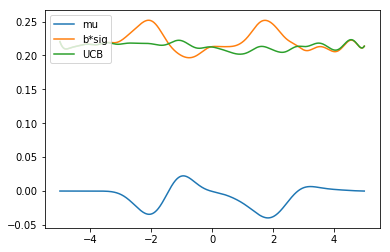

In [184]:
print "REFERENCE"
actions = np.linspace(-5.0,5.0,1000)
INDEX = -1
def plot_reference(m,actions):
    mus = []
    var = []
    tot = []
    for a in actions:
        out = integrate_dim(m,SDIM, a, b,B)
        mus.append(out[0])
        var.append(BETA*np.sqrt(out[1]))
        tot.append(out[0] + BETA*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
    
    
    
plot_reference(gps[-1],actions)

# plot_reference(m,actions)

In [ ]:
actions = np.linspace(-5.0,5.0,1000)

def plot_errors(m,gps):
    mus1 = []
    mus2 = []
    for a in actions:
        out1 = integrate_dim(m, SDIM, a, b,B)
        mus1.append(out1[0])
    for i, gp in enumerate(gps):
        mus2 = []
        for a in actions:
            out2 = integrate_dim(gp, SDIM, a, b,B)
            mus2.append(out2[0])
        plt.clf()
        plt.title("Integral Estimate - 3 Sdim - 1 Adim -Iteration %d" % i)
        plt.plot(actions, mus1, 'r', lw=2)
        plt.plot(actions, mus2, 'b', lw=2)
        plt.ylabel('integral of f(s,a)ds')
        plt.xlabel('actions')
        plt.savefig("./imgs/%i.png" % i)

INDEX = -1
def plot_error(m,gp):
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    plt.plot(actions, mus,label='groundtruth')
    plt.plot(actions, preds,label='gp')
    plt.legend(loc='upper left')
    plt.show()
# plot_error(m,gps[-1])
plot_errors(m,gps)

[-1.14432926  1.97982114] 1.1761646560088397
[-1.14432926  1.97982114] 1.1778960675861447


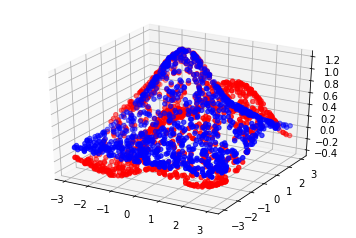

In [53]:
actions = np.random.uniform(-3.0,3.0, (1000, ADIM))

def plot_3d(m,gp):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mus = np.array([])
    preds = np.array([])
    for a in actions:
        mus = np.append(mus,integrate_dim(m,SDIM, a, b,B)[0])
        preds = np.append(preds,integrate_dim(gp,SDIM, a, b,B)[0])
    print actions[mus.argmax()], mus.max()
    print actions[preds.argmax()], preds.max()
    ax.scatter(actions[:,0], actions[:,1], mus,c='r')
    ax.scatter(actions[:,0], actions[:,1], preds,c='b')
    plt.show()
plot_3d(m,gps[-1])

In [36]:
a = np.array([2.0])

In [38]:
np.append(a,10.0)

array([ 2., 10.])